Model accuracy: 0.956694214876033
(14116, 2)


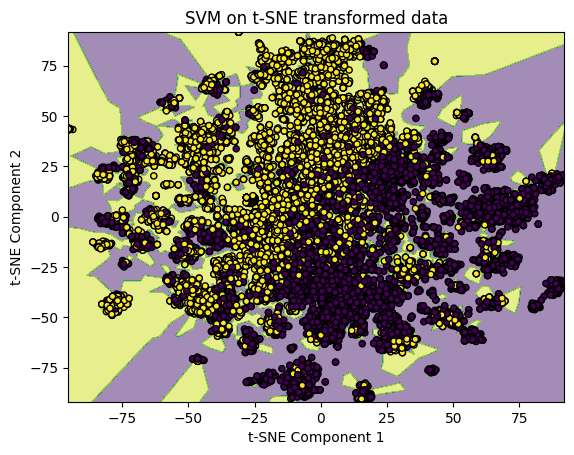

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from clean_data import clean_text

# Get the current working directory
current_dir = os.getcwd()

# Adjust the path to the project root (assuming the notebook is two levels deep in the folder structure)
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

# Add the project root to the Python path
sys.path.append(project_root)

# Load the dataset
csv_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'datasets', 'trainEN.csv'))
df = pd.read_csv(csv_path)

# Combine columns of title and text
df['combined_text'] = df['title'] + " " + df['text']
df['clean_text'] = df['combined_text'].apply(clean_text)

# Vectorize the dataset
X = df['clean_text']
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and fit the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize the SVC model and the PCA transformer
clf = SVC(C=19.0011, gamma=1.50001, kernel='rbf')
pca = TruncatedSVD(n_components=85)

# Transform the training and test data
X_train_pca = pca.fit_transform(X_train_vectorized)
X_test_pca = pca.transform(X_test_vectorized)

# Fit the model on the transformed training data
clf.fit(X_train_pca, y_train)

# Score the model on the transformed test data
score = clf.score(X_test_pca, y_test)
print("Model accuracy:", score)

# Apply t-SNE for visualization
X_train_embedded = TSNE(n_components=2).fit_transform(X_train_pca)
print(X_train_embedded.shape)

# Predict using the trained model
y_predicted = clf.predict(X_train_pca)

# Plot decision regions using 1-NN on the t-SNE transformed data
h = .02  # mesh step
resolution = 1000  # 1000x1000 background pixels
X2d_xmin, X2d_xmax = np.min(X_train_embedded[:, 0]), np.max(X_train_embedded[:, 0])
X2d_ymin, X2d_ymax = np.min(X_train_embedded[:, 1]), np.max(X_train_embedded[:, 1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# Approximate Voronoi tessellation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_train_embedded, y_predicted)
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

# Plot
plt.contourf(xx, yy, voronoiBackground, alpha=0.5)
plt.scatter(X_train_embedded[:, 0], X_train_embedded[:, 1], c=y_train, edgecolor='k', s=20)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('SVM on t-SNE transformed data')
plt.show()
